In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from astropy.io import fits

In [6]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [7]:
x = fits.open('/home/mabitbol/GBT-S140/externaldata/destripingdata_bankA_session5.fits')

In [8]:
banka = x[0].data
#banka[banka==0] = np.nan

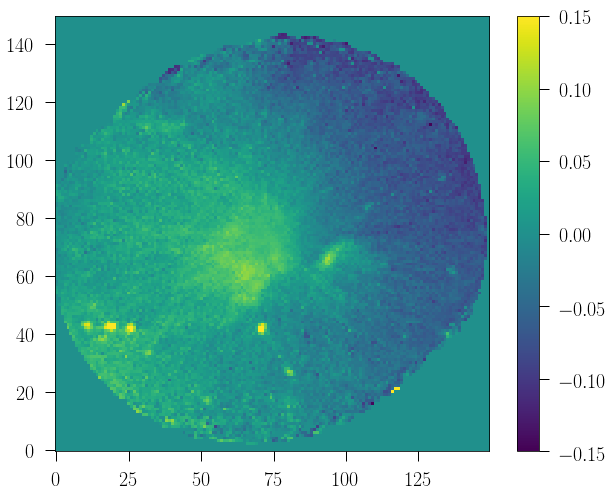

In [9]:
figure()
imshow(banka, origin='lower')
clim(-.15, .15)
colorbar()

In [10]:
figure()
pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
#pc = pcolormesh(rabinsc, decbinsc, outerregion)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
title('$6.2~GHz$')

NameError: name 'rabinsc' is not defined

In [11]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [12]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [13]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=0, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-15, 15)
        cb = colorbar()
        xlabel('$\mathrm{Lon}\ (deg)$')
        ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        #savefig('s4map_bank'+bank+'session'+session)
    
    print np.nansum(signal[innerregion])
    return rabinsc, decbinsc, signal

In [ ]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=1.)

TypeError: For this input type lists must contain either int or Ellipsis

In [22]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=None, doplot=False)

34.0901809149


In [23]:
gridx, gridy = np.meshgrid(rabinsc, decbinsc)

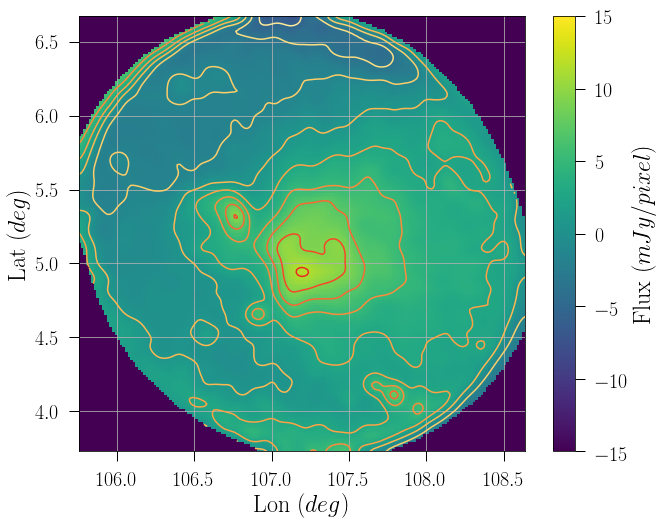

In [24]:
pcolormesh(rabinsc, decbinsc, signal*1000)
clim(-15, 15)
cb = colorbar()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_mapoverlay_A5')

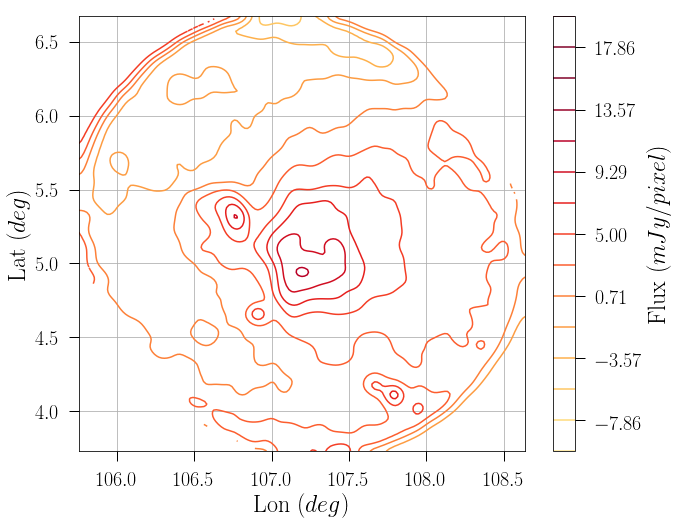

In [25]:
figure()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
clim(-15, 15)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_A5')

In [26]:
z = np.load('../externaldata/dustdata_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

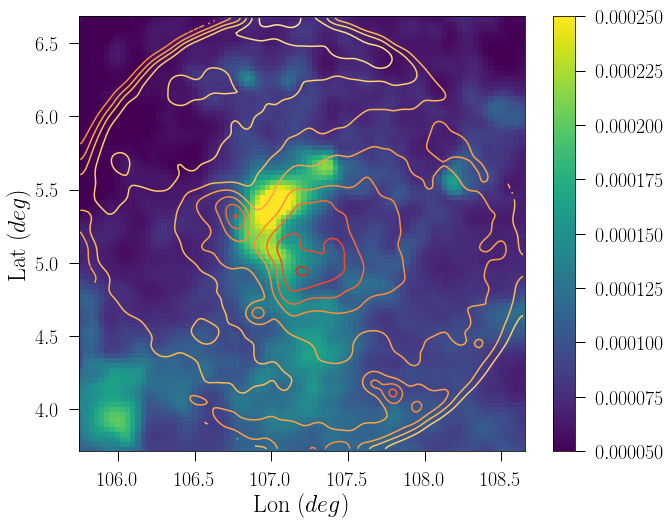

In [27]:
pcolormesh(dlons, dlats, dsig)
clim(0.00005, 0.00025)
colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#savefig('dustopacity_gbt_contours')

In [28]:
z = np.load('../externaldata/planck_30_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

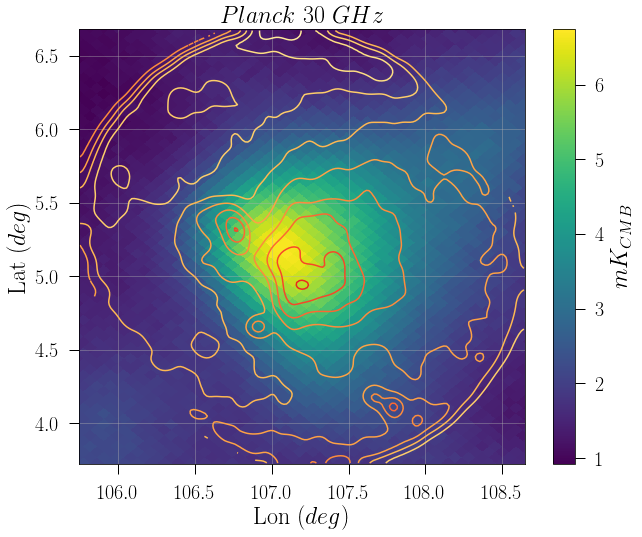

In [30]:
pcolormesh(dlons, dlats, dsig*1000.)
#clim(0.0, 3)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$mK_{CMB}$', labelpad=10)
title('$Planck\ 30~GHz$')
grid(alpha=0.5)
#savefig('p70_gbt_contours')

In [20]:
z = np.load('../externaldata/planck100_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

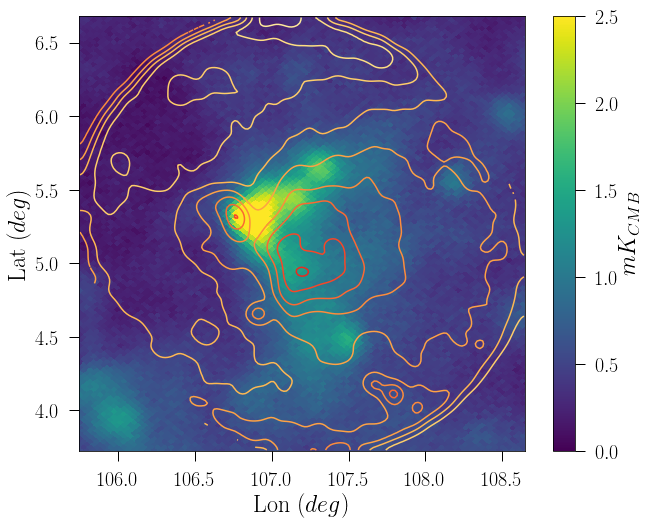

In [21]:
pcolormesh(dlons, dlats, dsig*1000.)
clim(0.0, 2.5)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$mK_{CMB}$')
savefig('p100_gbt_contours')

In [122]:
z = np.load('../externaldata/planck545_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

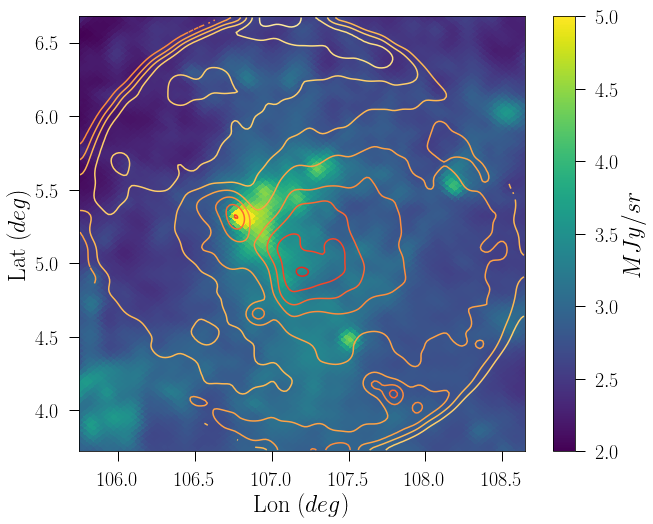

In [129]:
pcolormesh(dlons, dlats, np.log(dsig))
clim(2, 5)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$MJy/sr$')
#savefig('p545_gbt_contours')

In [24]:
z = np.load('../externaldata/halpha_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

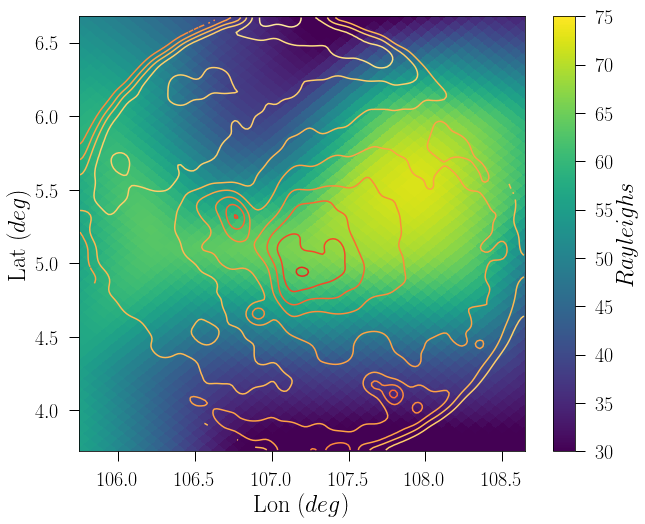

In [25]:
pcolormesh(dlons, dlats, dsig)
clim(30, 75)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$Rayleighs$')
savefig('halpha_gbt_contours')

In [26]:
z = np.load('../externaldata/haslam_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

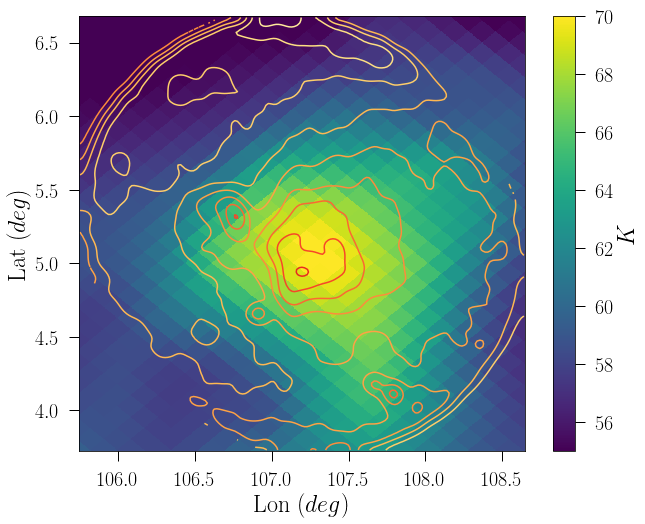

In [27]:
pcolormesh(dlons, dlats, dsig / 1000.)
clim(55, 70)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$K$')
savefig('haslam_gbt_contours')

In [16]:
z = np.load('../externaldata/iris_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

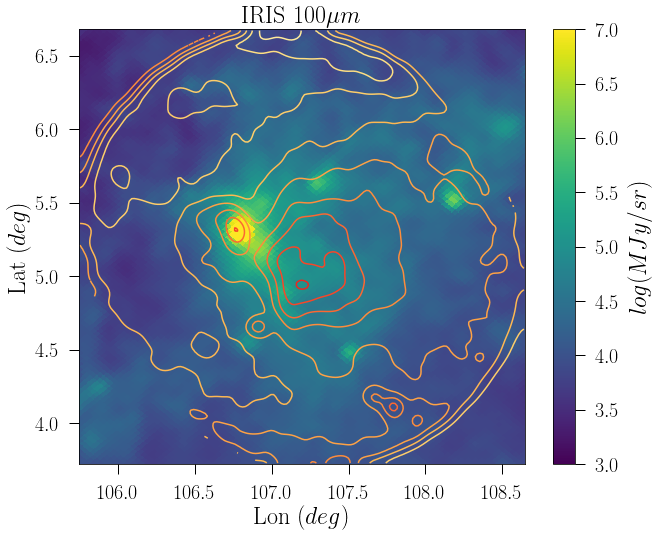

In [ ]:
pcolormesh(dlons, dlats, np.log(dsig))
clim(3, 7)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$log(MJy/sr)$', labelpad=10)
title('$\mathrm{IRIS}\ 100\mu m$')
savefig('iris_gbt_contours')

In [48]:
z = np.load('../externaldata/wssa_gridded.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

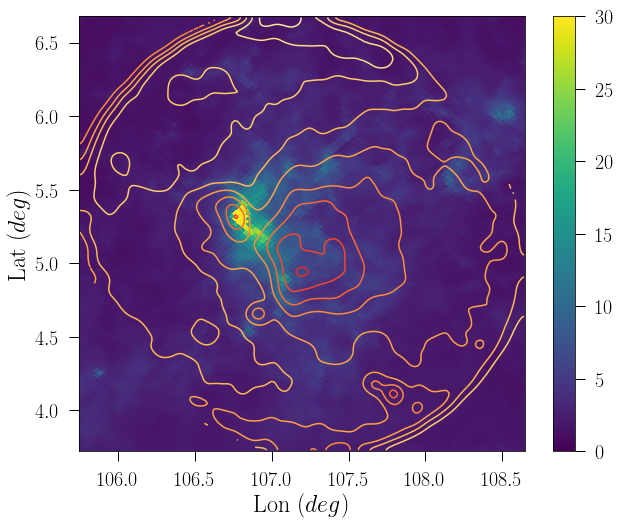

In [49]:
pcolormesh(dlons, dlats, dsig)
clim(0, 30)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#cm.set_label('$K$')
#savefig('wise_gbt_contours')

In [14]:
z = np.load('../externaldata/cgps.npz')
dlons = z['lons']
dlats = z['lats']
dsig = z['signal']

In [17]:
xmask = (dlons > gridx.min()) * (dlons < gridx.max())

In [18]:
ymask = (dlats > gridy.max()) * (dlats < gridy.max())

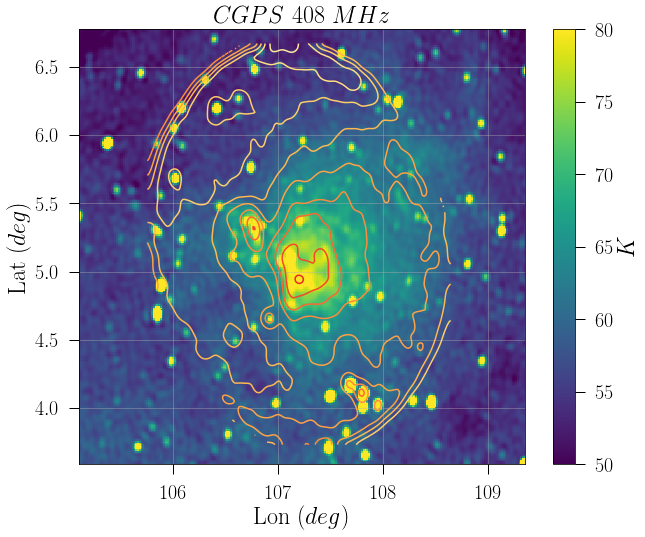

In [15]:
pcolormesh(dlons[xmask], dlats[ymask], dsig[xmask,:][])
clim(50, 80)
cm = colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cm.set_label('$K$')
title('$CGPS\ 408~MHz$')
grid(alpha=0.5)
#savefig('digitized_cgps2')

In [21]:
24 * 365

8760

In [11]:
import glob

In [12]:
fgrid = glob.glob('/home/mabitbol/GBT-S140/externaldata/*gridded.npz')
fgrid.sort()

In [13]:
fgrid

[u'/home/mabitbol/GBT-S140/externaldata/COline_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/Dustreconstructed_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/IRIS1_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/IRIS2_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/IRIS3_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/IRIS_SFD4_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/Thermaldust_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/dustdata_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/halpha2_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/halpha_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/haslam_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/iris_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/planck100_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/planck545_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/planck_100_gridded.npz',
 u'/home/mabitbol/GBT-S140/externaldata/planck_143_gridded

In [16]:
fgrid[10].split('/')[-1].split('gridded')[0]

u'haslam_'

In [17]:
for fn in fgrid:
    z = np.load(fn)
    dlons = z['lons']
    dlats = z['lats']
    dsig = z['signal']
    figure()
    pcolormesh(dlons, dlats, dsig)
    cm = colorbar();
    contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
    xlabel('$\mathrm{Lon}\ (deg)$')
    ylabel('$\mathrm{Lat}\ (deg)$')
    sname = fn.split('/')[-1].split('gridded')[0] + '_gbt_contours'
    savefig(sname)
    close()